In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import tri
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

In [13]:
# Step 1: Define problem parameters
L = 40  # Length of domain in x and y directions
T0 = 100
Nx, Ny = L, L  # Number of grid points in x and y
alpha = 2  # Thermal diffusivity
h = 0.5206164
print(h ** 2 / (2 * alpha))
dt = 0.0125  # Time step size
nt = 2000  # Number of time steps

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64
print(device)

0.06776035898723999
cpu


In [14]:
def apply_boundary_condition(A, b):
    pass

def create_preconditioner(A):
    sparse_indices = A._indices()
    sparse_values = A._values()
    
    PC = torch.zeros(A.shape[0], device=device, dtype=dtype)
    for i in range(sparse_indices.shape[1]):
        row, col = sparse_indices[:, i]
        if row == col:  # Check if it's a diagonal element
            PC[row] = sparse_values[i] 
    
    return PC


def apply_preconditioner(PC, r, tol=1e-6, max_iter=10):
    z = (1 / PC) * r
    # z = torch.linalg.solve(PC, r)
    return z

def conjugate_gradient(A, b, M, a_tol=1e-6, r_tol=1e-6, max_iter=100):
    
    x = torch.zeros_like(b, device=device, dtype=dtype)  # Initial guess (zero vector)
    r = b - A @ x            # Initial residual
    z = apply_preconditioner(M, r)  # Preconditioned residual
    p = z                    # Initial search direction

    r_norm = torch.linalg.vector_norm(r)
    
    for i in range(max_iter):
        Ap = A @ p           # Matrix-vector product A*p
        rz_scala = torch.dot(r, z)
        alpha = rz_scala / torch.dot(p, Ap)  # Step size
        
        # Update the solution
        x = x + alpha * p
        
        # Update residual
        r_new = r - alpha * Ap
        
        r_new_norm = torch.linalg.vector_norm(r_new)
        # print(r_new_norm / r_norm)
        
        if r_new_norm < a_tol or (r_new_norm / r_norm) < r_tol:
            print(f"Converged in {i} iterations", r_new_norm < a_tol, (r_new_norm / r_norm) < r_tol)
            break
        
        # Apply the preconditioner iteratively
        z_new = apply_preconditioner(M, r_new)
        
        # Compute beta for the next search direction
        beta = torch.dot(r_new, z_new) / rz_scala
        
        # Update the search direction
        p = z_new + beta * p
        
        # Update residuals and preconditioned residuals for next iteration
        r = r_new
        z = z_new
        
    else:
        print(f"Did not converge in {i} iterations", r_new_norm < a_tol, (r_new_norm / r_norm) < r_tol)
    return x

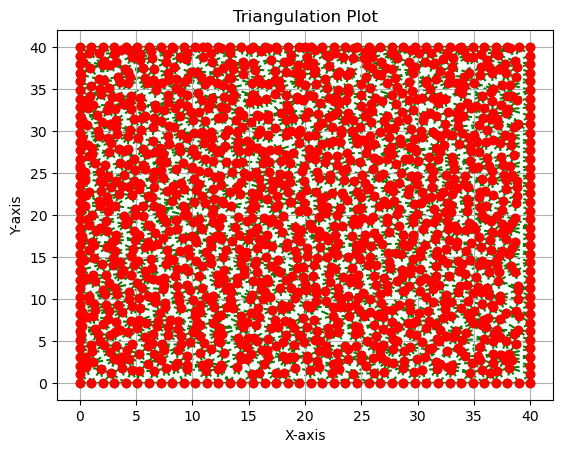

In [15]:
# Create the grid
x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
X, Y = np.meshgrid(x, y)
Y[1:L-1, 1: L-1] += np.random.rand(L-2, L-2) 
X[1:L-1, 1: L-1] -= np.random.rand(L-2, L-2)

# Create the original triangulation
triangulation = tri.Triangulation(X.flatten(), Y.flatten())
plt.figure()
plt.triplot(triangulation, 'go--')  # Plot the triangulation lines
plt.plot(X, Y, 'ro')  # Plot the original points
plt.title('Triangulation Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid()
plt.show()

In [16]:
# Step 3: Initial condition
u0 = torch.zeros((L * L,)).to(device=device, dtype=dtype)
u0[30 * L: 30 * L + L] = T0

In [17]:
def shape_function_gradients():
    # Gradients of shape functions in the reference element (master triangle)
    return torch.tensor([[-1, -1], 
                         [1, 0], 
                         [0, 1]], dtype=dtype)

def jacobian(coords):
    # Compute the Jacobian matrix for the transformation from reference to physical element
    dN_dxi = shape_function_gradients()  # Gradients in reference space
    J = coords.T @ dN_dxi  # Jacobian matrix: 2x2 for the triangle
    
    return J

def assemble_matrices(triangulation, alpha):
    npoints = len(triangulation.x)  # Total number of points in the mesh
    
    # Lists to store the indices and values of non-zero elements for K and M
    rows, cols, K_vals, M_vals = [], [], [], []
    
    for element in triangulation.triangles:
        # Get the coordinates of the three vertices of the triangle
        vertices = element[:]
        coords = torch.tensor([[x, y] for x, y in zip(triangulation.x[vertices], triangulation.y[vertices])], dtype=dtype)
        
        ###############################################################################################################
        # Calculate area of the triangle using the determinant method
        area = 0.5 * torch.linalg.det(torch.tensor([
            [1, coords[0, 0], coords[0, 1]],
            [1, coords[1, 0], coords[1, 1]],
            [1, coords[2, 0], coords[2, 1]]
        ]))
        # print(area)
        # Mass matrix for a triangular element
        Me = (area / 12) * torch.tensor([[2, 0, 0],
                                         [0, 2, 0],
                                         [0, 0, 2]])  # Consistent mass matrix for triangular elements

        # Compute Jacobian and its inverse
        J = jacobian(coords)
        det_J = torch.linalg.det(J)   # determinant of the Jacobian matrix (related to area)
        inv_J = torch.linalg.inv(J)
        
        # Compute the gradients of the shape functions in physical space (using the Jacobian inverse)
        dN_dxi = shape_function_gradients()
        dN_dxy = inv_J @ dN_dxi.T  # Now this is dN/dx and dN/dy in physical space (2x3 matrix)

        # Stiffness matrix
        Ke = np.zeros((3, 3))
        for i in range(3):
            for j in range(3):
                Ke[i, j] = alpha * det_J * (dN_dxy[0, i] * dN_dxy[0, j] + dN_dxy[1, i] * dN_dxy[1, j]) 
        ################################################################################################################
        # Add local contributions to the global matrices
        for i in range(3):
            for j in range(3):
                # Store K and M values in sparse form (row, col, value)
                rows.append(vertices[i])
                cols.append(vertices[j])
                K_vals.append(Ke[i, j])
                M_vals.append(Me[i, j])
    
    # Create sparse tensors from the accumulated lists
    K = torch.sparse_coo_tensor(
        indices=[rows, cols],
        values=K_vals,
        size=(npoints, npoints)
    )
    
    M = torch.sparse_coo_tensor(
        indices=[rows, cols],
        values=M_vals,
        size=(npoints, npoints)
    )
    
    return K, M

K, M = assemble_matrices(triangulation, alpha)
K = K.to(device=device, dtype=dtype)
M = M.to(device=device, dtype=dtype)

In [18]:
U = torch.zeros((nt, L, L)).to(device=device, dtype=dtype)
U[0,:,:] = u0.reshape((L, L))

u = u0
M_dt = M * (1 / dt)
A = M_dt + K

In [19]:
dirichlet_boundary_nodes = torch.arange(30 * L, 30 * L + L, device=device)
boundary_values = torch.ones_like(dirichlet_boundary_nodes, device=device, dtype=dtype) * T0

sparse_indices = A._indices() # apply boundary condition
sparse_values = A._values()

mask = ~torch.isin(sparse_indices[0], dirichlet_boundary_nodes) 
new_indices = sparse_indices[:, mask]
new_values = sparse_values[mask]

identity_indices = torch.stack([dirichlet_boundary_nodes, dirichlet_boundary_nodes], dim=0).to(device=device, dtype=dtype)  # Diagonal indices
identity_values = torch.ones_like(dirichlet_boundary_nodes)  # Diagonal values are set to 1.0

final_indices = torch.cat([new_indices, identity_indices], dim=1)
final_values = torch.cat([new_values, identity_values])
A = torch.sparse_coo_tensor(final_indices, final_values, A.shape)

PC = create_preconditioner(A)

In [20]:
for n in range(1, nt):
    print(f"{n}", end=" ")
    b = torch.sparse.mm(M_dt, u.unsqueeze(1)).squeeze(1)
    
    b[dirichlet_boundary_nodes] = boundary_values # apply boundary condition
    u = conjugate_gradient(A, b, PC, a_tol=1e-5, r_tol=1e-5, max_iter=100)
    
    U[n, :, :] = u.reshape((L, L))

1 Did not converge in 99 iterations tensor(False) tensor(False)
2 Converged in 22 iterations tensor(False) tensor(True)
3 Converged in 25 iterations tensor(False) tensor(True)
4 Converged in 29 iterations tensor(False) tensor(True)
5 Converged in 30 iterations tensor(False) tensor(True)
6 Converged in 32 iterations tensor(False) tensor(True)
7 Converged in 34 iterations tensor(False) tensor(True)
8 Converged in 35 iterations tensor(False) tensor(True)
9 Converged in 35 iterations tensor(False) tensor(True)
10 Converged in 36 iterations tensor(False) tensor(True)
11 Converged in 36 iterations tensor(False) tensor(True)
12 Converged in 36 iterations tensor(False) tensor(True)
13 Converged in 37 iterations tensor(False) tensor(True)
14 Converged in 37 iterations tensor(False) tensor(True)
15 Converged in 36 iterations tensor(False) tensor(True)
16 Converged in 37 iterations tensor(False) tensor(True)
17 Converged in 37 iterations tensor(False) tensor(True)
18 Converged in 38 iterations te

In [21]:
def plotheatmap(tr, u_k , k):
    plt.clf()

    plt.title(f"Temperature at t = {k*dt:.3f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    plt.tripcolor(tr, u_k.flatten(), cmap=plt.cm.jet, vmin=0, vmax=100, shading='gouraud')
    plt.colorbar()

In [22]:
U = U.cpu()
def animate(k):
    plotheatmap(triangulation, U[k], k)

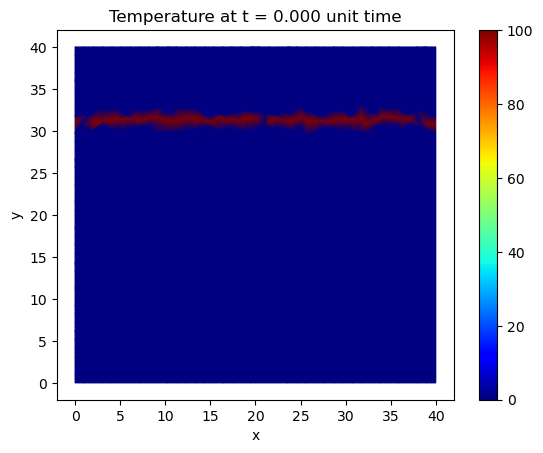

In [23]:
anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=nt, repeat=False)
anim.save("FEM - 2D Heat Equation - PCG - Sparse.gif")